### Gino's playground

In [3]:
# IMPORTS
import datadotworld as dw
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils import *

In [4]:
# Datasets
valuations = pd.read_csv('https://query.data.world/s/y4qg2twfvou4w2ghz6o3evju32g7yn?dws=00000') 
players = pd.read_csv('https://query.data.world/s/gksm6hx4xzgjaed7tia2uzpafwvyjo?dws=00000')
ratings22 = pd.read_csv("../data/raw/FIFA22_player_ratings.csv") # FIFA player attributes from 2022
ratings21 = pd.read_csv("../data/raw/FIFA21_player_ratings.csv") # FIFA player attributes from 2022
# This appends players from 2021 not present in 2022
extended = set(ratings21.sofifa_id).difference(set(ratings22.sofifa_id))
ratings = pd.concat([ratings22, ratings21[ratings21.sofifa_id.isin(extended)]]).reset_index()

process = False

FileNotFoundError: [Errno 2] No such file or directory: '../data/players_ratings_22.csv'

In [3]:
# Keep only useful columns
players = players[['player_id', 'first_name', 'last_name', 'name', 'last_season', 
                   'country_of_birth', 'city_of_birth', 'country_of_citizenship', 'date_of_birth', 'sub_position', 
                   'position', 'foot', 'height_in_cm', 'market_value_in_eur', 'highest_market_value_in_eur', 
                   'contract_expiration_date', 'current_club_domestic_competition_id', 'current_club_name']]

ratings = ratings[['short_name', 'long_name', 'player_positions', 'overall', 'potential', 'value_eur',
                   'wage_eur', 'age', 'dob', 'height_cm', 'weight_kg', 'club_team_id', 'club_name', 'league_name', 
                   'league_level', 'club_position', 'club_joined', 'club_contract_valid_until', 'nationality_name',
                   'preferred_foot', 'weak_foot', 'skill_moves', 'international_reputation', 'work_rate', 'body_type',
                   'release_clause_eur', 'player_tags', 'player_traits', 'pace', 'shooting', 'passing', 'dribbling', 
                   'defending', 'physic', 'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 
                   'attacking_short_passing', 'attacking_volleys', 'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 
                   'skill_long_passing', 'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 
                   'movement_reactions', 'movement_balance', 'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength', 
                   'power_long_shots', 'mentality_aggression', 'mentality_interceptions', 'mentality_positioning', 'mentality_vision', 
                   'mentality_penalties', 'mentality_composure', 'defending_marking_awareness', 'defending_standing_tackle', 
                   'defending_sliding_tackle', 'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking', 
                   'goalkeeping_positioning', 'goalkeeping_reflexes', 'goalkeeping_speed', 'ls', 'st', 'rs', 'lw', 'lf', 'cf', 'rf', 
                   'rw', 'lam', 'cam', 'ram', 'lm', 'lcm', 'cm', 'rcm', 'rm', 'lwb', 'ldm', 'cdm', 'rdm', 'rwb', 'lb', 'lcb', 'cb', 
                   'rcb', 'rb', 'gk']]


In [4]:
if process:
    # Find matches
    longname_matches = match_players(players, ratings)
    # Append the extracted FIFA long names
    players["FIFA_long_name"] = longname_matches
    # Re arrange columns
    players = players[list(players.columns[:4]) + [players.columns[-1]] + list(players.columns[4:-1])]
else:
    players = pd.read_csv("players_wFIFAnames.csv")

In [5]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19239 entries, 0 to 19238
Data columns (total 96 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   short_name                   19239 non-null  object 
 1   long_name                    19239 non-null  object 
 2   player_positions             19239 non-null  object 
 3   overall                      19239 non-null  int64  
 4   potential                    19239 non-null  int64  
 5   value_eur                    19165 non-null  float64
 6   wage_eur                     19178 non-null  float64
 7   age                          19239 non-null  int64  
 8   dob                          19239 non-null  object 
 9   height_cm                    19239 non-null  int64  
 10  weight_kg                    19239 non-null  int64  
 11  club_team_id                 19178 non-null  float64
 12  club_name                    19178 non-null  object 
 13  league_name     

In [1]:
players.info()
players

NameError: name 'players' is not defined

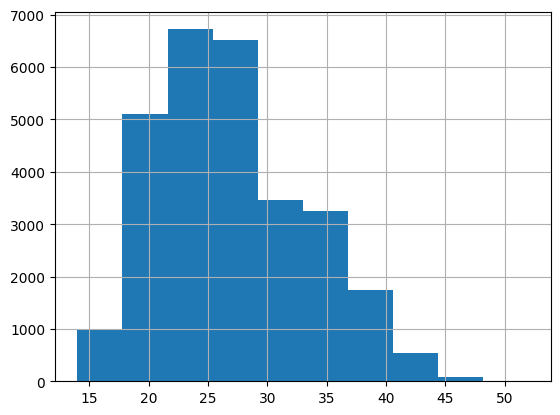

In [11]:
# Calculate players age to the data of data collection
players["age"] = players.date_of_birth.apply(lambda x: calculate_age(x))

(array([ 988., 5111., 6719., 6523., 3457., 3255., 1741.,  534.,   80.,
           9.]),
 array([14. , 17.8, 21.6, 25.4, 29.2, 33. , 36.8, 40.6, 44.4, 48.2, 52. ]),
 <BarContainer object of 10 artists>)

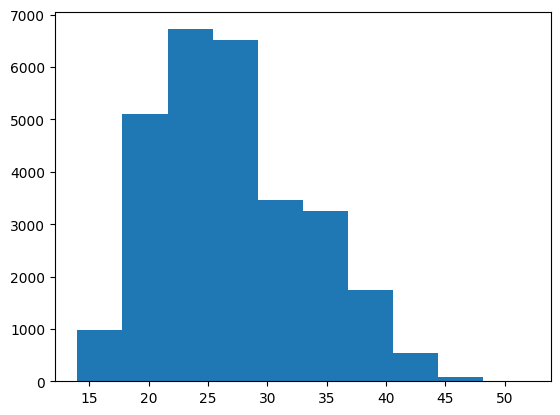

In [12]:
fig, ax = plt.subplots()

ax.hist(players.age)

In [8]:
# Detect retired:
## Conditions:
### Last season < 2021
### No current club (NAN)
### No Market value in EUR (NAN)
### No Contract Expiration date (NAN)
players.loc[(players.last_season < 2021) & (players.current_club_name.isna()) & (players.market_value_in_eur.isna()) & (players.contract_expiration_date.isna()), "age"].hist();

In [9]:
players.loc[(players.last_season < 2021) & (players.current_club_name.isna()) & (players.market_value_in_eur.isna()) & (players.contract_expiration_date.isna()), "age"].count()

3942

In [10]:
players.loc[6739]

player_id                                       844356
first_name                                       Petro
last_name                                     Velychko
name                                    Petro Velychko
FIFA_long_name                                     NaN
last_season                                       2020
country_of_birth                                   NaN
city_of_birth                                      NaN
country_of_citizenship                         Ukraine
date_of_birth                               2004-08-28
sub_position                               Centre-Back
position                                      Defender
foot                                             right
height_in_cm                                     190.0
market_value_in_eur                                NaN
highest_market_value_in_eur                        NaN
contract_expiration_date                           NaN
current_club_domestic_competition_id              UKR1
current_cl